# Logistic Regression (applied to dummy data)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

az.style.use('arviz-darkgrid')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Load raw data and plot

In [2]:
# read .csv file into Dataframe
data = pd.read_csv('../../data/test/dummy_data.csv')
data

,1200,1300,1400,1500,1600,1700,code,label
0,6.859681,9.472035,15.243682,8.041220,1.359436,0.569499,1,Arabica
1,6.309441,8.401346,15.041552,8.278361,1.028300,1.463044,1,Arabica
2,5.746870,8.223710,16.166272,7.937323,1.125077,1.658064,1,Arabica
3,6.884220,8.235310,16.066599,7.607464,1.831370,0.867443,1,Arabica
4,5.746478,8.615229,15.325160,7.945671,2.605825,1.126482,1,Arabica
5,5.276155,8.619932,8.136409,7.454639,2.973493,1.923625,2,Robusta
6,6.138655,9.805064,9.425262,8.270688,1.467806,0.466879,2,Robusta
7,6.072105,8.877384,8.498315,8.260295,1.528403,0.216872,2,Robusta
8,6.200951,9.619839,9.501848,8.088760,2.424705,1.398675,2,Robusta
9,6.823931,8.042763,9.400266,8.787564,1.583661,0.777459,2,Robusta


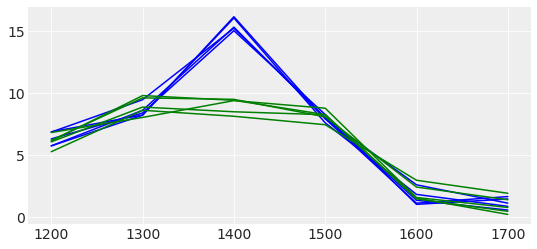

In [4]:
# header data = x-values
cols = data.columns.to_list()
x_val = np.array(cols[:-2], dtype='float32')

# plot all data in 1 figure
fig = plt.figure(figsize=(9,4))
ax = plt.axes()

for i in range(len(data)):
    y_val = data.values[i]
    if y_val[-2] == 1:
        col = 'blue'
    else:
        col = 'green'
    plt.plot(x_val, y_val[:-2], '-', color=col);

In [5]:
# extract X data from dataframe
X = data.iloc[:,:-2].to_numpy()
X.shape

(10, 6)

In [6]:
# extract Y data from dataframe
Y = data.iloc[:,-2].to_numpy()
Y.shape

(10,)

In [7]:
# add a column of ones to X
Xn = np.append(np.ones((X.shape[0],1)), X, axis=1)
Xn.shape

(10, 7)

## Model definition

In [200]:
with pm.Model() as model_mlr:
    beta = pm.Normal('beta', mu=0, sd=2, shape=Xn.shape[1])
    epsilon = pm.HalfCauchy('epsilon', 2)
    
    mu = pm.math.dot(Xn, beta)

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=Y)

    trace_mlr = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, beta]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:53<00:00, 55.56draws/s]
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


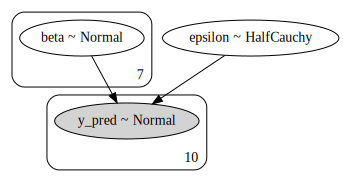

In [212]:
pm.model_to_graphviz(model_mlr)

In [201]:
az.summary(trace_mlr)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta[0],1.166,1.867,-2.159,4.898,0.091,0.064,421.0,421.0,417.0,456.0,1.00
beta[1],-0.069,0.218,-0.491,0.299,0.008,0.006,669.0,579.0,627.0,747.0,1.00
beta[2],0.113,0.161,-0.164,0.419,0.007,0.005,541.0,477.0,515.0,782.0,1.00
beta[3],-0.133,0.030,-0.182,-0.077,0.001,0.001,1033.0,1033.0,957.0,779.0,1.01
beta[4],0.164,0.256,-0.275,0.645,0.010,0.009,618.0,393.0,587.0,670.0,1.01
beta[5],0.081,0.215,-0.303,0.452,0.009,0.007,521.0,521.0,499.0,811.0,1.00
beta[6],-0.071,0.241,-0.534,0.377,0.009,0.007,786.0,570.0,790.0,643.0,1.01
epsilon,0.246,0.143,0.107,0.474,0.009,0.006,268.0,268.0,229.0,177.0,1.02


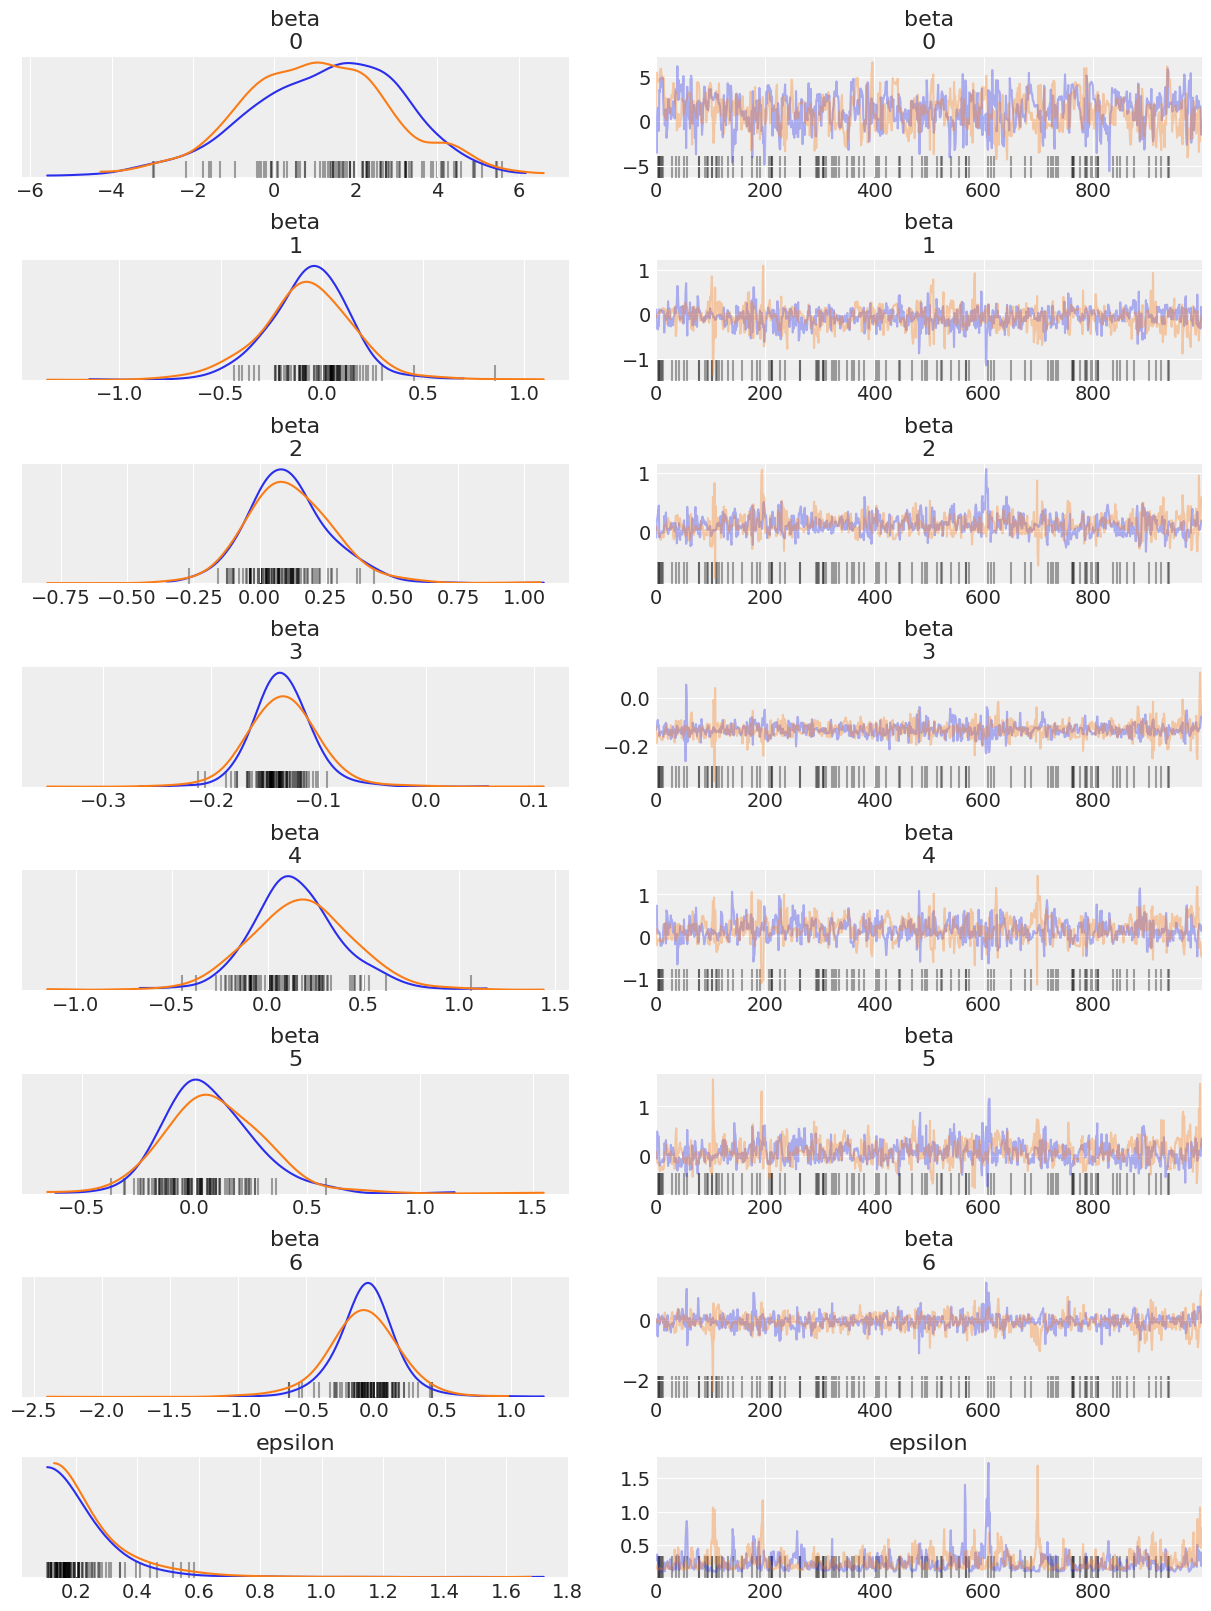

In [202]:
az.plot_trace(trace_mlr);

In [211]:
#pm.autocorrplot(trace_mlr);
#pm.traceplot(trace_mlr);
#pm.plot_posterior(trace_mlr, kde_plot=True);

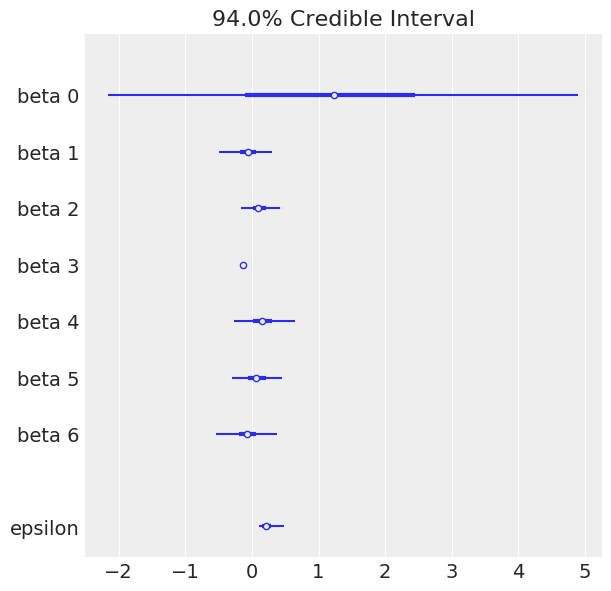

In [204]:
az.plot_forest(trace_mlr, combined=True);

In [206]:
ppc = pm.sample_posterior_predictive(trace_mlr, samples=1000, model=model_mlr)

100%|██████████| 1000/1000 [00:00<00:00, 1057.11it/s]


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


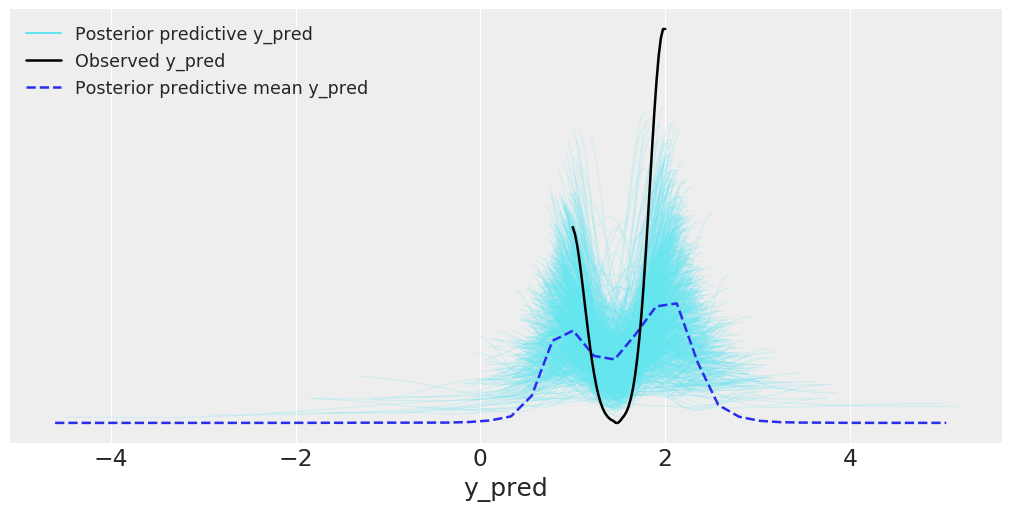

In [207]:
data_ppc = az.from_pymc3(trace=trace_mlr, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(10, 5), mean=True)